# **Plant disease classification**
### Deep Learning and Applications part 1
Cocco Mattia 65336 and Lepuri Tomas 65358

Università degli Studi di Cagliari

## **Introduction**

This project focuses on plant disease classification from leaves pictures.

The dataset employed is available at https://www.kaggle.com/datasets/emmarex/plantdisease .

The algorithms exploited to solve this problem are:
- custom CNN
- ResNet (pre-trained)
- ResNet (fine-tuned)

Report is available at https://github.com/Matti02co/dla-project-2526 .

## **Import and environment setup**

In this preliminary section we import the useful packages and set up cuda for better performance.

In [ ]:
import kagglehub    #for dataset
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import Counter


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## **Dataset download**

In [ ]:
# Dataset download and class examples print
path = kagglehub.dataset_download("emmarex/plantdisease")

data_dir = os.path.join(path, "PlantVillage")
print(os.listdir(data_dir)[:5])

Using Colab cache for faster access to the 'plantdisease' dataset.
['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot']


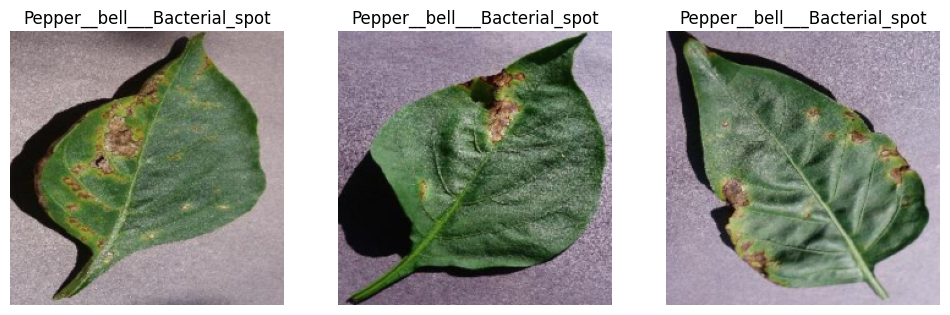

In [ ]:
# Visualizzation transform and image examples print
transform_vis = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

vis_dataset = datasets.ImageFolder(data_dir, transform=transform_vis)

fig, axes = plt.subplots(1, 3, figsize=(12,6))

for i, ax in enumerate(axes.flatten()):
    img, label = vis_dataset[i]
    img = img.permute(1, 2, 0)  # CHW → HWC
    ax.imshow(img)
    ax.set_title(vis_dataset.classes[label])
    ax.axis('off')

plt.show()

## **Preprocessing**

In this section a few crucial operations are performed:
- image resizing (standard size for ResNet)
- data augmentation in training set (transformations introduction)
- image conversion (from HWC to CHW)
- normalization (ImageNet standard)

The dataset is split in training, validation and test sets (60%-20%-20%) and DataLoader are created.

A concatenated training-validation set is kept for final tests.

Transformations are performed separately, to augment only data in the training set.

Batch size is set to 256, which is a best practice for ResNets.

In [ ]:
# training set transform creation
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# test set transform creation
transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])


In [ ]:
full_dataset = datasets.ImageFolder(data_dir)

# defining split proportion
train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

# set split (randomized with seed for repetibility)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator = torch.Generator().manual_seed(42)
)

# concat for late tests
trainval_dataset = ConcatDataset([train_dataset, val_dataset])

In [ ]:
# transform application
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform  = transform_test
test_dataset.dataset.transform  = transform_test

# DataLoaders creation
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)

trainval_loader = DataLoader(trainval_dataset, batch_size=256, shuffle=True)


## **Custom CNN**

We defined a custom CNN, with 3 blocks containing:
- convolution
- activation
- pooling

Followed by the final classifier block:
- fully connected layer
- activation
- fully connected layer

We chose ReLU as activation function and MaxPooling in the pooling layers.

We also introduced 50% dropout in the training phase, following the first tests.

In [ ]:
# CNN definition
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),        # 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),        # 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)         # 28x28
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)   # flatten
        x = self.classifier(x)
        return x


The model print shows the information provided above.

In [ ]:
num_classes = len(full_dataset.classes)

model = CustomCNN(num_classes).to(device)
print(model)

CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=15, bias=True)
  )
)


We then set:
- Loss function: Cross Entropy
- Optimizer: Adaptive moment estimation (Adam) with 1e-3 learning rate for the moment

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

At this point we defined three functions to train and evaluate the model.

In [ ]:
def train_epoch(model, loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)                # forward prop
        loss = criterion(out, y)      # loss calculation
        loss.backward()               # backward prop
        optimizer.step()

        # statistics returned
        running_loss += loss.item()
        _, preds = torch.max(out, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss/len(loader), correct/total

In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)                    # prediction
            _, preds = torch.max(out, 1)
            correct += (preds == y).sum().item()      # verification
            total += y.size(0)

    return correct / total

In [ ]:
def run_experiment(model, name, train_loader, test_loader, t, epochs=20):

    # 20 epochs is the default
    # dictionary initialization, t can be test or val
    results = {
        "train_loss": [],
        "train_acc": [],
        t + "_acc": []
    }

    # calculate loss and accuracies per epoch, save them and print them
    for epoch in range(epochs):
        loss, acc = train_epoch(model, train_loader)
        test_acc = evaluate(model, test_loader)

        results["train_loss"].append(loss)
        results["train_acc"].append(acc)
        results[t + "_acc"].append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {loss:.4f} - "
              f"Train acc: {acc:.4f} - "
              f"{t} acc: {test_acc:.4f}")

    return results

Finally, we defined a dictionary for the results, trained and tested the CNN (on validation set).

(Here dropout and data augmentation were not implemented yet)

In [ ]:
all_results = {}

In [ ]:
all_results["Custom CNN"] = run_experiment(model, "Custom CNN", train_loader, val_loader, "val")

Epoch 1/20 - Loss: 1.8884 - Train acc: 0.4609 - val acc: 0.6957
Epoch 2/20 - Loss: 0.6841 - Train acc: 0.7776 - val acc: 0.7868
Epoch 3/20 - Loss: 0.4476 - Train acc: 0.8529 - val acc: 0.8437
Epoch 4/20 - Loss: 0.2818 - Train acc: 0.9058 - val acc: 0.8539
Epoch 5/20 - Loss: 0.2129 - Train acc: 0.9292 - val acc: 0.8503
Epoch 6/20 - Loss: 0.1465 - Train acc: 0.9531 - val acc: 0.9053
Epoch 7/20 - Loss: 0.0755 - Train acc: 0.9788 - val acc: 0.9028
Epoch 8/20 - Loss: 0.0522 - Train acc: 0.9844 - val acc: 0.9009
Epoch 9/20 - Loss: 0.0346 - Train acc: 0.9899 - val acc: 0.8961
Epoch 10/20 - Loss: 0.0391 - Train acc: 0.9881 - val acc: 0.9116
Epoch 11/20 - Loss: 0.0125 - Train acc: 0.9974 - val acc: 0.9164
Epoch 12/20 - Loss: 0.0187 - Train acc: 0.9956 - val acc: 0.9150
Epoch 13/20 - Loss: 0.0090 - Train acc: 0.9983 - val acc: 0.9157
Epoch 14/20 - Loss: 0.0019 - Train acc: 1.0000 - val acc: 0.9249
Epoch 15/20 - Loss: 0.0008 - Train acc: 1.0000 - val acc: 0.9251
Epoch 16/20 - Loss: 0.0006 - Train

The results are shown in the charts below.

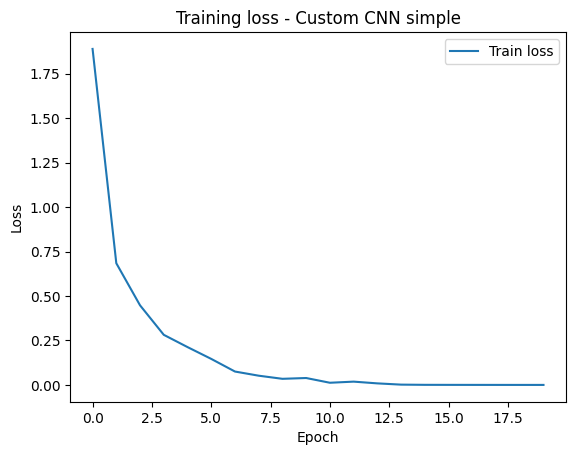

In [ ]:
res = all_results["Custom CNN"]

plt.figure()
plt.plot(res["train_loss"], label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss - Custom CNN simple")
plt.legend()
plt.show()

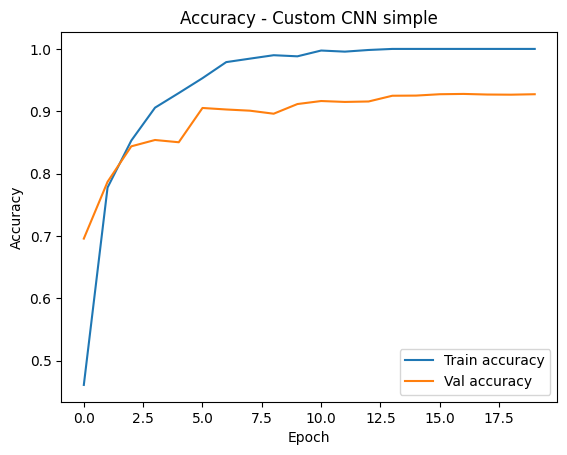

In [ ]:
plt.figure()
plt.plot(res["train_acc"], label="Train accuracy")
plt.plot(res["val_acc"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy - Custom CNN simple")
plt.legend()
plt.show()

### **Data augmentation and dropout**

We added data augmentation to the training set and dropout to fight overfitting and repeated the tests (validation set).

In [ ]:
# set model, loss and optimizer
model = CustomCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
all_results["Custom CNN aug dropout"] = run_experiment(model, "Custom CNN aug dropout", train_loader, val_loader, "val")

Slightly better results were obteined.

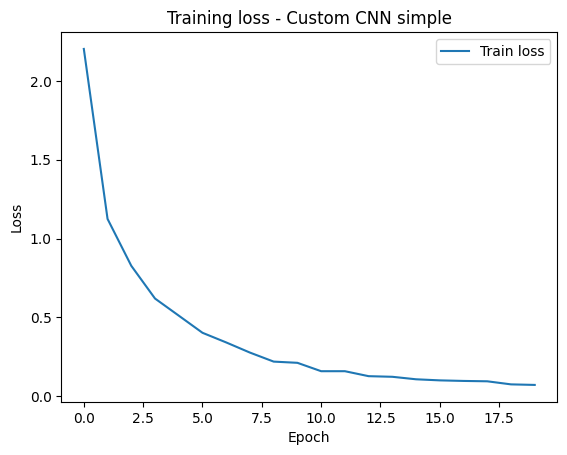

In [ ]:
res = all_results["Custom CNN aug dropout"]

plt.figure()
plt.plot(res["train_loss"], label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss - Custom CNN simple")
plt.legend()
plt.show()

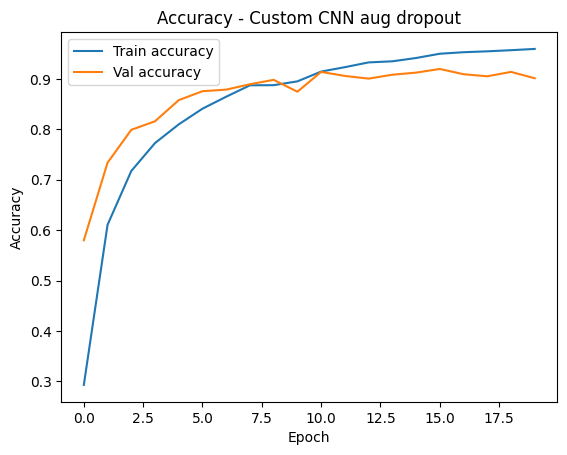

In [ ]:
plt.figure()
plt.plot(res["train_acc"], label="Train accuracy")
plt.plot(res["val_acc"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy - Custom CNN aug dropout")
plt.legend()
plt.show()

### **Learning rate tuning**

At this point, we decided to make a few tests to find out the best learning rate and the number of epochs.

The test were executed in training and validation sets.

We selected the learning rates we wanted to test.

In [ ]:
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]

We created the dictionary for the temporary results.

In [ ]:
results_lr = {}

And we ran the tests for each learning rate (20 epochs).

In [ ]:
for lr in learning_rates:
    print(f"\nTraining CNN with lr = {lr}")

    # model, optimizer and loss
    model = CustomCNN(num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # initialization
    train_accs = []
    val_accs = []

    epochs = 20

    # training and test for learning rate
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader)
        val_acc = evaluate(model, val_loader)

        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1} - "
              f"Train acc: {train_acc:.4f} - "
              f"Val acc: {val_acc:.4f}")

    # save each result
    results_lr[lr] = {
        "train_acc": train_accs,
        "val_acc": val_accs,
        "best_val_acc": max(val_accs)
    }



Training CNN with lr = 0.0001
Epoch 1 - Train acc: 0.4428 - Val acc: 0.6576
Epoch 2 - Train acc: 0.6487 - Val acc: 0.7521
Epoch 3 - Train acc: 0.7205 - Val acc: 0.7836
Epoch 4 - Train acc: 0.7624 - Val acc: 0.8185
Epoch 5 - Train acc: 0.7962 - Val acc: 0.8423
Epoch 6 - Train acc: 0.8238 - Val acc: 0.8575
Epoch 7 - Train acc: 0.8395 - Val acc: 0.8614
Epoch 8 - Train acc: 0.8520 - Val acc: 0.8767
Epoch 9 - Train acc: 0.8663 - Val acc: 0.8803
Epoch 10 - Train acc: 0.8797 - Val acc: 0.8803
Epoch 11 - Train acc: 0.8836 - Val acc: 0.8944
Epoch 12 - Train acc: 0.8908 - Val acc: 0.8948
Epoch 13 - Train acc: 0.9015 - Val acc: 0.9007
Epoch 14 - Train acc: 0.9091 - Val acc: 0.9050
Epoch 15 - Train acc: 0.9159 - Val acc: 0.9028
Epoch 16 - Train acc: 0.9251 - Val acc: 0.9084
Epoch 17 - Train acc: 0.9294 - Val acc: 0.9111
Epoch 18 - Train acc: 0.9332 - Val acc: 0.9123
Epoch 19 - Train acc: 0.9327 - Val acc: 0.9108
Epoch 20 - Train acc: 0.9444 - Val acc: 0.9179

Training CNN with lr = 0.0003
Epoch 1

The results are shown below.

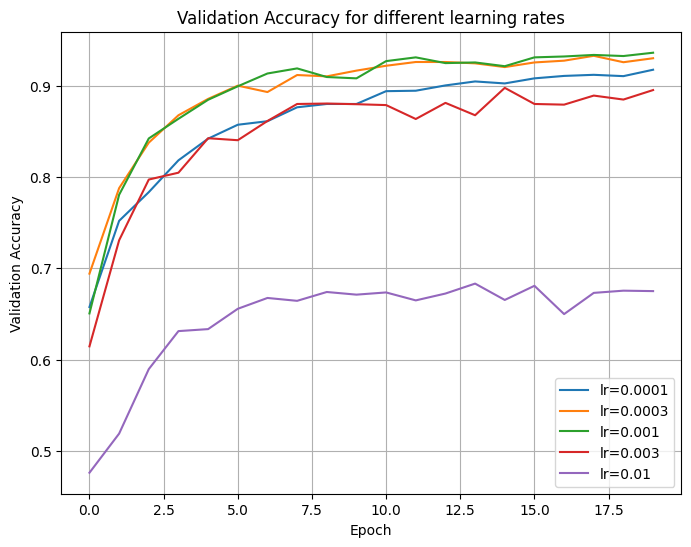

In [ ]:
plt.figure(figsize=(8,6))

for lr, res in results_lr.items():
    plt.plot(res["val_acc"], label=f"lr={lr}")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy for different learning rates")
plt.legend()
plt.grid(True)
plt.show()

It turned out that learning rate of 1e-3 (0.001), which is the one used since the beginning, is argueably the best one.

The direction of the top curves suggest that increasing the number of epochs may lead to further improvements.

### **Increasing epochs**

So we run a test doubling the number of epochs

In [ ]:
# set model, loss and optimizer
model = CustomCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

all_results["Custom CNN 40 epochs"] = run_experiment(model, "Custom CNN", train_loader, val_loader, "val", epochs=40)

Epoch 1/40 - Loss: 1.9821 - Train acc: 0.3893 - val acc: 0.6378
Epoch 2/40 - Loss: 1.0009 - Train acc: 0.6753 - val acc: 0.7916
Epoch 3/40 - Loss: 0.6990 - Train acc: 0.7708 - val acc: 0.8151
Epoch 4/40 - Loss: 0.5532 - Train acc: 0.8189 - val acc: 0.8503
Epoch 5/40 - Loss: 0.4429 - Train acc: 0.8515 - val acc: 0.8931
Epoch 6/40 - Loss: 0.3547 - Train acc: 0.8814 - val acc: 0.9087
Epoch 7/40 - Loss: 0.2872 - Train acc: 0.9049 - val acc: 0.9188
Epoch 8/40 - Loss: 0.2474 - Train acc: 0.9183 - val acc: 0.9125
Epoch 9/40 - Loss: 0.1997 - Train acc: 0.9332 - val acc: 0.9246
Epoch 10/40 - Loss: 0.1875 - Train acc: 0.9383 - val acc: 0.9259
Epoch 11/40 - Loss: 0.1385 - Train acc: 0.9531 - val acc: 0.9341
Epoch 12/40 - Loss: 0.1251 - Train acc: 0.9559 - val acc: 0.9314
Epoch 13/40 - Loss: 0.1101 - Train acc: 0.9619 - val acc: 0.9273
Epoch 14/40 - Loss: 0.1029 - Train acc: 0.9635 - val acc: 0.9309
Epoch 15/40 - Loss: 0.0921 - Train acc: 0.9678 - val acc: 0.9300
Epoch 16/40 - Loss: 0.0846 - Train

The results are shown below.

No significant improvements and accuracy seems stable

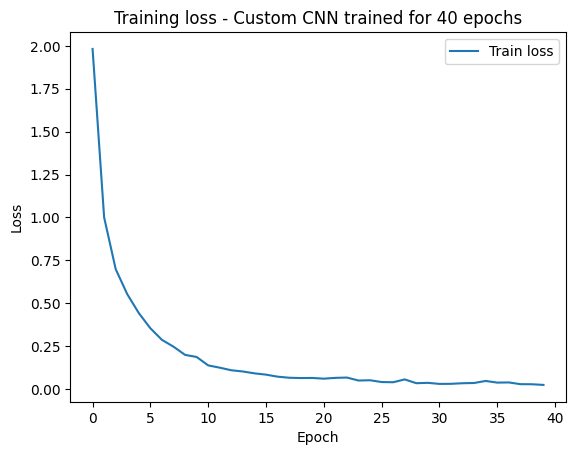

In [ ]:
res = all_results["Custom CNN 40 epochs"]

plt.figure()
plt.plot(res["train_loss"], label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss - Custom CNN trained for 40 epochs")
plt.legend()
plt.show()

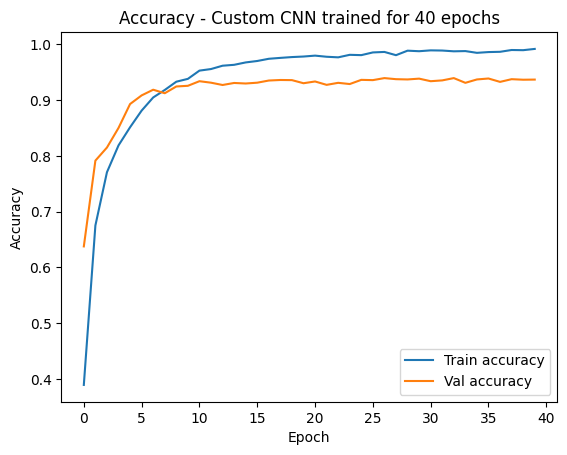

In [ ]:
plt.figure()
plt.plot(res["train_acc"], label="Train accuracy")
plt.plot(res["val_acc"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy - Custom CNN trained for 40 epochs")
plt.legend()
plt.show()

### **Dataset normalization test**

In the first phase, we adopted mean and std of ImageNet for consistency with the ResNet.

In this section we tested the network, computing mean and std on this very dataset (per channel) (separately, to avoid data leakage).

In [ ]:
# simple utility function to compute mean and std
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=256, shuffle=False)
    mean = 0.
    std = 0.
    total_images = 0

    # for each image
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

Two new transforms are defined, we kept data augmentation in the training set.

In [ ]:
mean, std = compute_mean_std(train_dataset)

transform_training2 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

mean, std = compute_mean_std(test_dataset)

transform_test2 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

In [ ]:
full_dataset = datasets.ImageFolder(data_dir)

# defining split proportion
train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

# set split (randomized)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator = torch.Generator().manual_seed(42)
)

# transform application
train_dataset.dataset.transform = transform_training2
val_dataset.dataset.transform  = transform_test2
test_dataset.dataset.transform  = transform_test2

# DataLoaders creation
train_loader2 = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader2   = DataLoader(val_dataset,   batch_size=256, shuffle=False)
test_loader2  = DataLoader(test_dataset,  batch_size=256, shuffle=False)


We then tested this variation (still on validation set).

In [ ]:
# set model, loss and optimizer
model = CustomCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

all_results["Custom CNN norm"] = run_experiment(model, "Custom CNN norm", train_loader2, val_loader2, "val")

Epoch 1/20 - Loss: 2.2663 - Train acc: 0.2931 - val acc: 0.5798
Epoch 2/20 - Loss: 1.2165 - Train acc: 0.6106 - val acc: 0.7337
Epoch 3/20 - Loss: 0.8633 - Train acc: 0.7173 - val acc: 0.7989
Epoch 4/20 - Loss: 0.6865 - Train acc: 0.7727 - val acc: 0.8158
Epoch 5/20 - Loss: 0.5688 - Train acc: 0.8097 - val acc: 0.8578
Epoch 6/20 - Loss: 0.4717 - Train acc: 0.8408 - val acc: 0.8755
Epoch 7/20 - Loss: 0.4070 - Train acc: 0.8646 - val acc: 0.8786
Epoch 8/20 - Loss: 0.3401 - Train acc: 0.8872 - val acc: 0.8893
Epoch 9/20 - Loss: 0.3296 - Train acc: 0.8874 - val acc: 0.8980
Epoch 10/20 - Loss: 0.3106 - Train acc: 0.8950 - val acc: 0.8745
Epoch 11/20 - Loss: 0.2569 - Train acc: 0.9144 - val acc: 0.9137
Epoch 12/20 - Loss: 0.2260 - Train acc: 0.9231 - val acc: 0.9057
Epoch 13/20 - Loss: 0.1950 - Train acc: 0.9326 - val acc: 0.9004
Epoch 14/20 - Loss: 0.1925 - Train acc: 0.9347 - val acc: 0.9082
Epoch 15/20 - Loss: 0.1698 - Train acc: 0.9413 - val acc: 0.9123
Epoch 16/20 - Loss: 0.1468 - Train

The results are shown below.

Performance is actually worse.

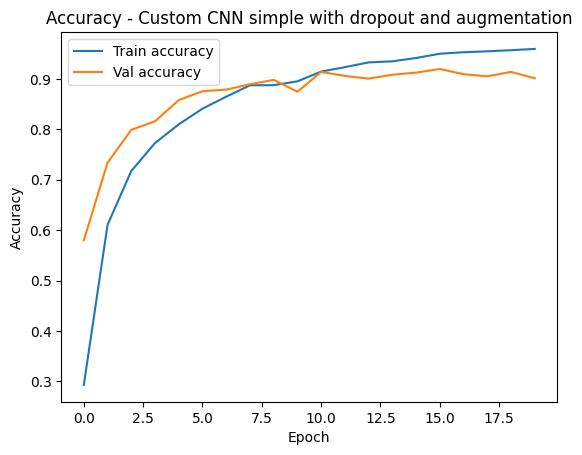

In [ ]:
res = all_results["Custom CNN norm"]

plt.figure()
plt.plot(res["train_acc"], label="Train accuracy")
plt.plot(res["val_acc"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy - Custom CNN simple with dropout and augmentation")
plt.legend()
plt.show()

### **Final custom CNN test**

Finally, our CNN was tested on the test set, with the best configuration found:
- learning rate 1e-3
- dropout + data augmentation
- ImageNet normalization
- 20 epochs

In [ ]:
# set model, loss, optimizer
model = CustomCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# create new dictionary for test results on test set
test_results = {}
test_results["Custom CNN"] = run_experiment(model, "Custom CNN", trainval_loader, test_loader, "test")

Epoch 1/20 - Loss: 1.4445 - Train acc: 0.5443 - test acc: 0.7670
Epoch 2/20 - Loss: 0.6345 - Train acc: 0.7916 - test acc: 0.8772
Epoch 3/20 - Loss: 0.4378 - Train acc: 0.8556 - test acc: 0.8939
Epoch 4/20 - Loss: 0.3317 - Train acc: 0.8899 - test acc: 0.9201
Epoch 5/20 - Loss: 0.2515 - Train acc: 0.9188 - test acc: 0.9223
Epoch 6/20 - Loss: 0.2046 - Train acc: 0.9323 - test acc: 0.9385
Epoch 7/20 - Loss: 0.1864 - Train acc: 0.9376 - test acc: 0.9448
Epoch 8/20 - Loss: 0.1399 - Train acc: 0.9517 - test acc: 0.9457
Epoch 9/20 - Loss: 0.1259 - Train acc: 0.9575 - test acc: 0.9438
Epoch 10/20 - Loss: 0.1071 - Train acc: 0.9626 - test acc: 0.9496
Epoch 11/20 - Loss: 0.0932 - Train acc: 0.9690 - test acc: 0.9424
Epoch 12/20 - Loss: 0.0909 - Train acc: 0.9694 - test acc: 0.9535
Epoch 13/20 - Loss: 0.0877 - Train acc: 0.9700 - test acc: 0.9448
Epoch 14/20 - Loss: 0.0660 - Train acc: 0.9790 - test acc: 0.9477
Epoch 15/20 - Loss: 0.0595 - Train acc: 0.9800 - test acc: 0.9528
Epoch 16/20 - Loss:

The results are shown below.

The network generalized well.

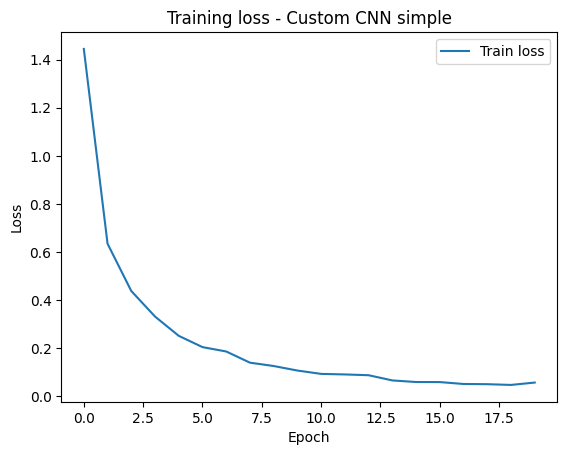

In [ ]:
res = test_results["Custom CNN"]

plt.figure()
plt.plot(res["train_loss"], label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss - Custom CNN simple")
plt.legend()
plt.show()

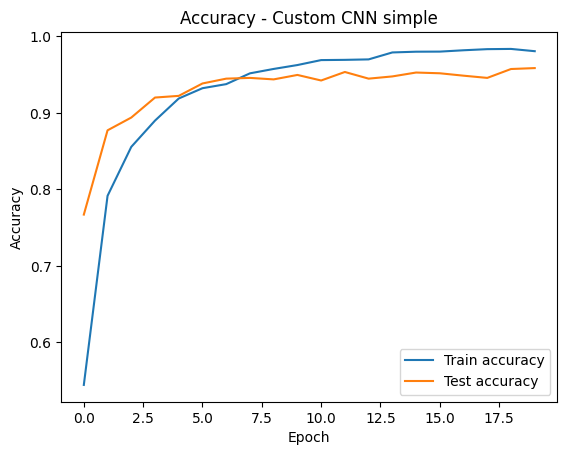

In [ ]:
plt.figure()
plt.plot(res["train_acc"], label="Train accuracy")
plt.plot(res["test_acc"], label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy - Custom CNN simple")
plt.legend()
plt.show()

## **ResNet (pre-trained)**

Once we analyzed the performance of our custom CNN, we decided to solve the problem with a very powerful network: ResNet (18)

To begin with, we downloaded the network and tested it exploiting the pre-training, without any fine-tuning.

In [ ]:
model = models.resnet18(pretrained=True)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 235MB/s]


We froze the weights of the ResNet and added a classifier layer (this will be trained).

In [ ]:
# freezing weights
for param in model.parameters():
    param.requires_grad = False

# adding fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Loss and optimizer are the same chosen for the custom CNN.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

Finally the pre-trained ResNet is tested, with the same routines defined before.

We ran the test directly on the test set, since the hyperparameters and configuration are the common one used in transfer learning for ResNets.

In [ ]:
test_results["ResNet Frozen"] = run_experiment(model, "ResNet Frozen", trainval_loader, test_loader, "test")


Epoch 1/20 - Loss: 1.5162 - Train acc: 0.6113 - Test acc: 0.8176
Epoch 2/20 - Loss: 0.6820 - Train acc: 0.8462 - Test acc: 0.8704
Epoch 3/20 - Loss: 0.4908 - Train acc: 0.8872 - Test acc: 0.8905
Epoch 4/20 - Loss: 0.4043 - Train acc: 0.9022 - Test acc: 0.9043
Epoch 5/20 - Loss: 0.3508 - Train acc: 0.9110 - Test acc: 0.9118
Epoch 6/20 - Loss: 0.3154 - Train acc: 0.9190 - Test acc: 0.9186
Epoch 7/20 - Loss: 0.2885 - Train acc: 0.9236 - Test acc: 0.9198
Epoch 8/20 - Loss: 0.2651 - Train acc: 0.9311 - Test acc: 0.9191
Epoch 9/20 - Loss: 0.2502 - Train acc: 0.9356 - Test acc: 0.9249
Epoch 10/20 - Loss: 0.2354 - Train acc: 0.9378 - Test acc: 0.9249
Epoch 11/20 - Loss: 0.2247 - Train acc: 0.9403 - Test acc: 0.9300
Epoch 12/20 - Loss: 0.2152 - Train acc: 0.9416 - Test acc: 0.9319
Epoch 13/20 - Loss: 0.2039 - Train acc: 0.9448 - Test acc: 0.9327
Epoch 14/20 - Loss: 0.1962 - Train acc: 0.9475 - Test acc: 0.9341
Epoch 15/20 - Loss: 0.1877 - Train acc: 0.9509 - Test acc: 0.9341
Epoch 16/20 - Loss:

The results are shown below.

Actually slightly worse than the custom CNN.

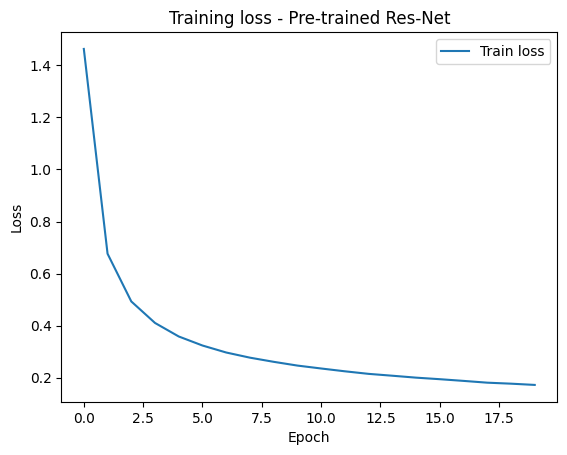

In [ ]:
res = test_results["ResNet Frozen"]

plt.figure()
plt.plot(res["train_loss"], label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss - Pre-trained Res-Net")
plt.legend()
plt.show()

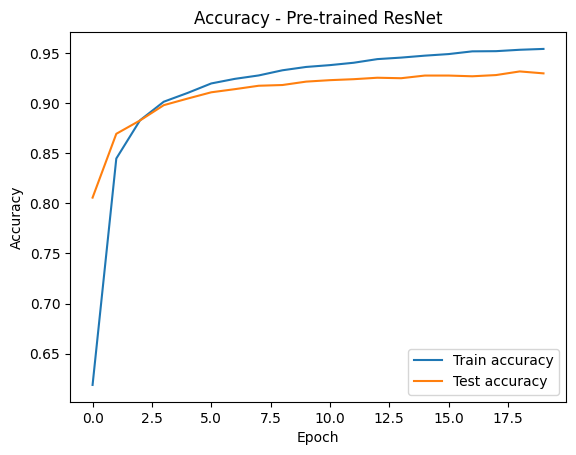

In [ ]:
plt.figure()
plt.plot(res["train_acc"], label="Train accuracy")
plt.plot(res["test_acc"], label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy - Pre-trained ResNet")
plt.legend()
plt.show()

## **ResNet fine-tuning**

In the following section we unlocked the weights of the last layer before training, in order to perform fine-tuning and compare the results.

In [ ]:
# unfreeze the last layer
for param in model.layer4.parameters():
    param.requires_grad = True

Loss Function and Optimizer are Cross Entropy and Adam as before.

We set learning rate to 1e-4, as common practice in fine-tuining, to avoid forgetting.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4,)

Finally we reused the same routines to train and test the model.

(On the test set even in this case)

In [ ]:
test_results["ResNet Fine-Tuned 4"] = run_experiment(model, "ResNet Fine-Tuned 4", trainval_loader, test_loader, "test")

Epoch 1/20 - Loss: 0.1072 - Train acc: 0.9681 - Test acc: 0.9709
Epoch 2/20 - Loss: 0.0085 - Train acc: 0.9996 - Test acc: 0.9797
Epoch 3/20 - Loss: 0.0028 - Train acc: 1.0000 - Test acc: 0.9809
Epoch 4/20 - Loss: 0.0015 - Train acc: 1.0000 - Test acc: 0.9816
Epoch 5/20 - Loss: 0.0011 - Train acc: 1.0000 - Test acc: 0.9809
Epoch 6/20 - Loss: 0.0009 - Train acc: 1.0000 - Test acc: 0.9826
Epoch 7/20 - Loss: 0.0007 - Train acc: 1.0000 - Test acc: 0.9821
Epoch 8/20 - Loss: 0.0006 - Train acc: 1.0000 - Test acc: 0.9828
Epoch 9/20 - Loss: 0.0004 - Train acc: 1.0000 - Test acc: 0.9826
Epoch 10/20 - Loss: 0.0004 - Train acc: 1.0000 - Test acc: 0.9833
Epoch 11/20 - Loss: 0.0003 - Train acc: 1.0000 - Test acc: 0.9828
Epoch 12/20 - Loss: 0.0003 - Train acc: 1.0000 - Test acc: 0.9830
Epoch 13/20 - Loss: 0.0003 - Train acc: 1.0000 - Test acc: 0.9838
Epoch 14/20 - Loss: 0.0002 - Train acc: 1.0000 - Test acc: 0.9833
Epoch 15/20 - Loss: 0.0002 - Train acc: 1.0000 - Test acc: 0.9840
Epoch 16/20 - Loss:

The results are shown below.

There is a big improvement.

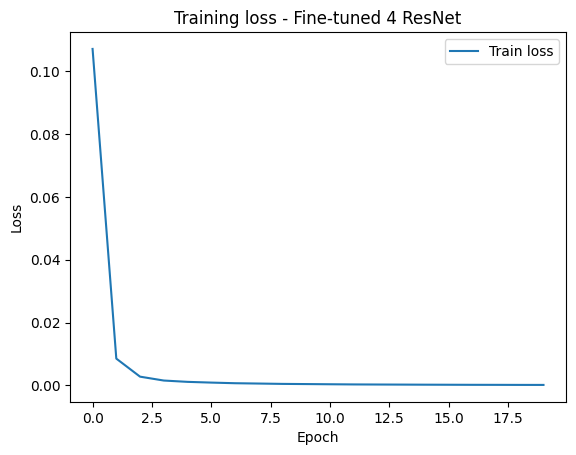

In [ ]:
res = test_results["ResNet Fine-Tuned 4"]

plt.figure()
plt.plot(res["train_loss"], label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss - Fine-tuned 4 ResNet")
plt.legend()
plt.show()

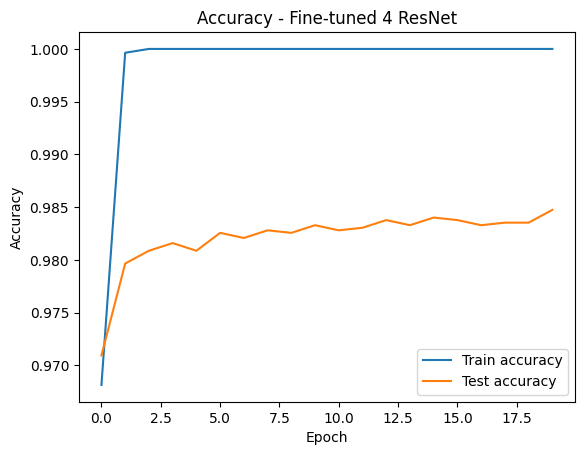

In [ ]:
plt.figure()
plt.plot(res["train_acc"], label="Train accuracy")
plt.plot(res["test_acc"], label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy - Fine-tuned 4 ResNet")
plt.legend()
plt.show()

## **ResNet fine-tuning 2**

In the following section we unlocked the weights of the last 2 layers before training, to see if we could increase performance furtherly. And we also used weight decay in the optimization.

In [ ]:
# unfreeze the third and the last layers
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.layer3.parameters():
    param.requires_grad = True

Loss Function is still Cross Entropy but we changed optimizer, choosing AdamW to set discoupled weight decay (1e-5 good practice).

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

Finally we reused the same routines to train and test the model on the test set.

In [ ]:
test_results["ResNet Fine-Tuned 3-4"] = run_experiment(model, "ResNet Fine-Tuned 3-4", trainval_loader, test_loader, "test")

Epoch 1/20 - Loss: 0.0877 - Train acc: 0.9727 - Test acc: 0.9847
Epoch 2/20 - Loss: 0.0056 - Train acc: 0.9996 - Test acc: 0.9884
Epoch 3/20 - Loss: 0.0016 - Train acc: 1.0000 - Test acc: 0.9889
Epoch 4/20 - Loss: 0.0008 - Train acc: 1.0000 - Test acc: 0.9893
Epoch 5/20 - Loss: 0.0006 - Train acc: 1.0000 - Test acc: 0.9898
Epoch 6/20 - Loss: 0.0005 - Train acc: 1.0000 - Test acc: 0.9913
Epoch 7/20 - Loss: 0.0004 - Train acc: 1.0000 - Test acc: 0.9903
Epoch 8/20 - Loss: 0.0003 - Train acc: 1.0000 - Test acc: 0.9906
Epoch 9/20 - Loss: 0.0002 - Train acc: 1.0000 - Test acc: 0.9901
Epoch 10/20 - Loss: 0.0002 - Train acc: 1.0000 - Test acc: 0.9898
Epoch 11/20 - Loss: 0.0002 - Train acc: 1.0000 - Test acc: 0.9908
Epoch 12/20 - Loss: 0.0002 - Train acc: 1.0000 - Test acc: 0.9893
Epoch 13/20 - Loss: 0.0001 - Train acc: 1.0000 - Test acc: 0.9910
Epoch 14/20 - Loss: 0.0001 - Train acc: 1.0000 - Test acc: 0.9896
Epoch 15/20 - Loss: 0.0001 - Train acc: 1.0000 - Test acc: 0.9906
Epoch 16/20 - Loss:

The results are shown below.

This is the best performance till now.

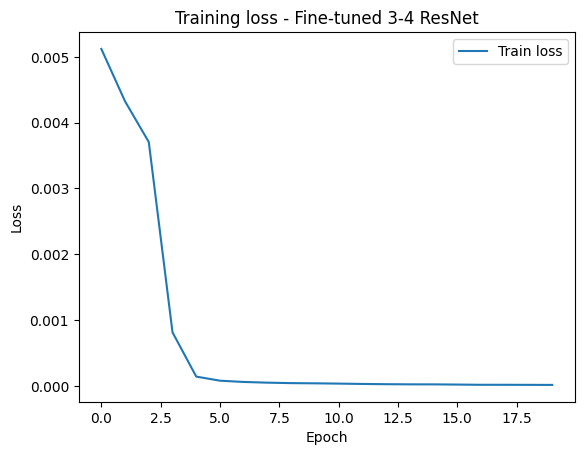

In [ ]:
res = test_results["ResNet Fine-Tuned 3-4"]

plt.figure()
plt.plot(res["train_loss"], label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss - Fine-tuned 3-4 ResNet")
plt.legend()
plt.show()

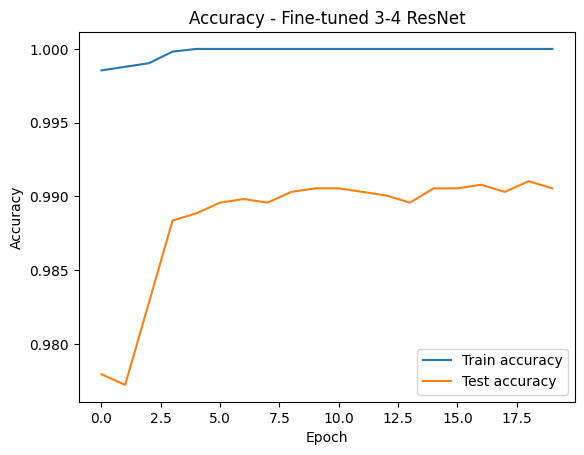

In [ ]:
plt.figure()
plt.plot(res["train_acc"], label="Train accuracy")
plt.plot(res["test_acc"], label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy - Fine-tuned 3-4 ResNet")
plt.legend()
plt.show()

## **Failure cases analysis**

At this point, we reached 99% accuracy on the test set.

We decided to dug deeper and see what images the net is having trouble with, to spot eventual problematic patterns or classes

In [ ]:
test_acc = evaluate(model, test_loader)
print(f"Test accuracy: {test_acc*100:.2f}%")

Test accuracy: 99.01%


We re evaluated the last model, to save information about errors

In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        _, preds = torch.max(out, 1)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

In [ ]:
errors = all_preds != all_labels
num_errors = np.sum(errors)

print(f"Total test samples: {len(all_labels)}")
print(f"Misclassified samples: {num_errors}")
print(f"Error rate: {num_errors/len(all_labels)*100:.2f}%")

Total test samples: 4128
Misclassified samples: 41
Error rate: 0.99%


Misclassified samples are 41.

We printed the confusion matrix, but nothing could be seen.

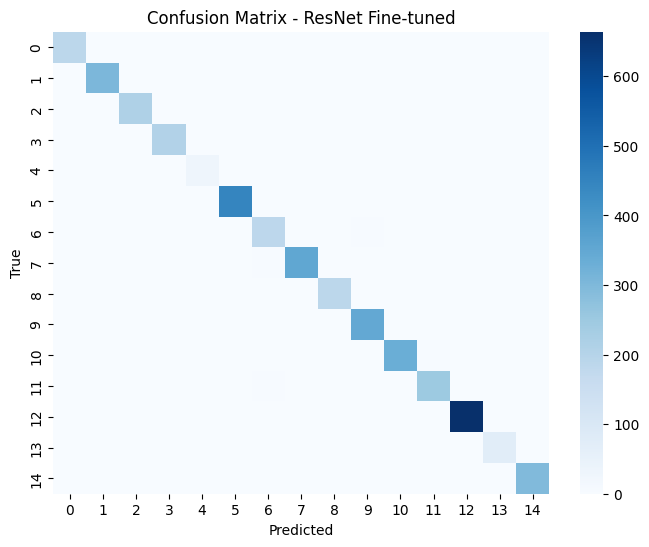

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ResNet Fine-tuned")
plt.show()

In [ ]:
# class legenda

classes = train_loader.dataset.dataset.classes

for i, cls in enumerate(classes):
    print(f"{i}: {cls}")


0: Pepper__bell___Bacterial_spot
1: Pepper__bell___healthy
2: Potato___Early_blight
3: Potato___Late_blight
4: Potato___healthy
5: Tomato_Bacterial_spot
6: Tomato_Early_blight
7: Tomato_Late_blight
8: Tomato_Leaf_Mold
9: Tomato_Septoria_leaf_spot
10: Tomato_Spider_mites_Two_spotted_spider_mite
11: Tomato__Target_Spot
12: Tomato__Tomato_YellowLeaf__Curl_Virus
13: Tomato__Tomato_mosaic_virus
14: Tomato_healthy


We printed some error examples.

We can see a weird image, which is probably the cause of that specific misclassification.

In [ ]:
error_indices = np.where(errors)[0]

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

# denormalization is needed to see correctly the images
def denormalize(img):
    img = img.permute(1,2,0).numpy()
    img = std * img + mean
    return np.clip(img, 0, 1)

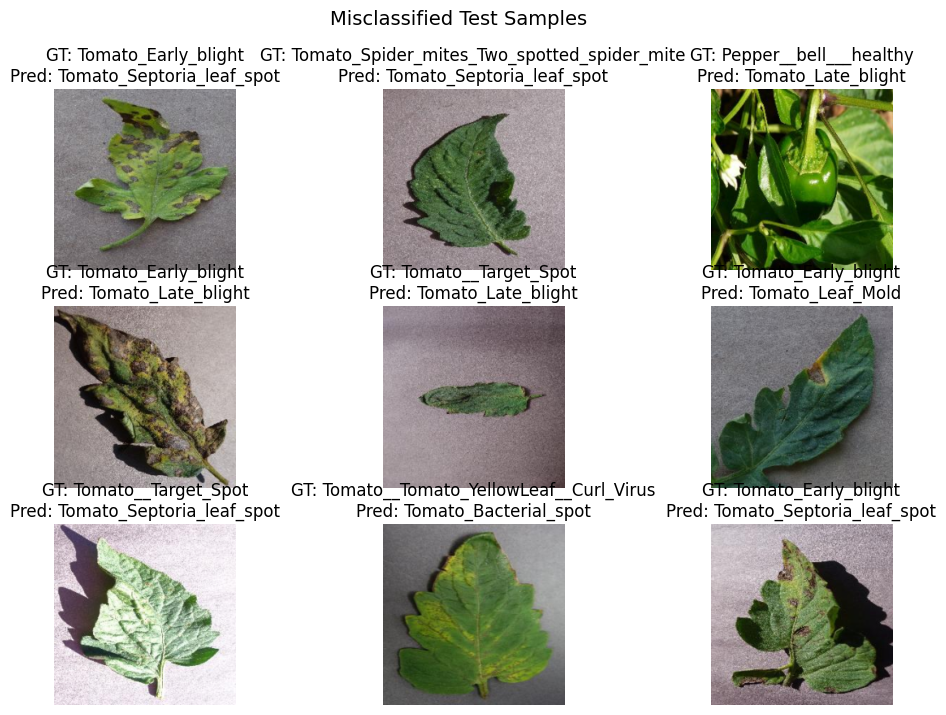

In [ ]:
classes = full_dataset.classes

plt.figure(figsize=(12,8))

for i, idx in enumerate(error_indices[:9]):
    img, label = test_dataset[idx]
    pred = all_preds[idx]

    # we print ground truth and prediction of the model
    plt.subplot(3,3,i+1)
    plt.imshow(denormalize(img))
    plt.title(f"GT: {classes[label]}\nPred: {classes[pred]}")
    plt.axis("off")

plt.suptitle("Misclassified Test Samples", fontsize=14)
plt.show()


We printed number of errors per class and error rates, spotting some common misclassified classes.

In [ ]:
error_labels = all_labels[errors]

error_count = Counter(error_labels)

print("Errors per class:")
for cls_idx, count in error_count.most_common():
    print(f"{classes[cls_idx]:30s}: {count}")

Errors per class:
Tomato_Early_blight           : 10
Tomato__Target_Spot           : 9
Tomato_Spider_mites_Two_spotted_spider_mite: 6
Tomato_Late_blight            : 6
Tomato_Leaf_Mold              : 4
Potato___Late_blight          : 3
Pepper__bell___healthy        : 1
Tomato__Tomato_YellowLeaf__Curl_Virus: 1
Potato___Early_blight         : 1


In [ ]:
class_total = Counter(all_labels)

print("\nError rate per class:")
for cls in range(len(classes)):
    errors_cls = error_count.get(cls, 0)
    total_cls = class_total.get(cls, 0)
    rate = errors_cls / total_cls if total_cls > 0 else 0
    print(f"{classes[cls]:30s}: {rate*100:6.2f}%")



Error rate per class:
Pepper__bell___Bacterial_spot :   0.00%
Pepper__bell___healthy        :   0.33%
Potato___Early_blight         :   0.47%
Potato___Late_blight          :   1.42%
Potato___healthy              :   0.00%
Tomato_Bacterial_spot         :   0.00%
Tomato_Early_blight           :   5.10%
Tomato_Late_blight            :   1.66%
Tomato_Leaf_Mold              :   2.09%
Tomato_Septoria_leaf_spot     :   0.00%
Tomato_Spider_mites_Two_spotted_spider_mite:   1.77%
Tomato__Target_Spot           :   3.47%
Tomato__Tomato_YellowLeaf__Curl_Virus:   0.15%
Tomato__Tomato_mosaic_virus   :   0.00%
Tomato_healthy                :   0.00%


For better understanding, we printed the top confusions.

The model is not mistaking diseased plants for healthy ones, which is good.

The main difficulties are linked to blight, spider mite and target spot.

In [ ]:
confusions = []

for true, pred in zip(all_labels[errors], all_preds[errors]):
    confusions.append((true, pred))

conf_counter = Counter(confusions)

print("\nTop confusions:")
for (true, pred), count in conf_counter.most_common(10):
    print(f"{classes[true]} → {classes[pred]} : {count}")


Top confusions:
Tomato_Spider_mites_Two_spotted_spider_mite → Tomato__Target_Spot : 5
Tomato_Late_blight → Tomato_Early_blight : 5
Tomato_Early_blight → Tomato_Septoria_leaf_spot : 3
Tomato__Target_Spot → Tomato_Early_blight : 3
Tomato_Early_blight → Tomato_Late_blight : 2
Tomato_Leaf_Mold → Tomato_Septoria_leaf_spot : 2
Tomato_Leaf_Mold → Tomato_Spider_mites_Two_spotted_spider_mite : 2
Tomato__Target_Spot → Tomato_Bacterial_spot : 2
Potato___Late_blight → Tomato_Late_blight : 2
Tomato_Spider_mites_Two_spotted_spider_mite → Tomato_Septoria_leaf_spot : 1


We also printed the error rate chart, to visualize better what we already knew.

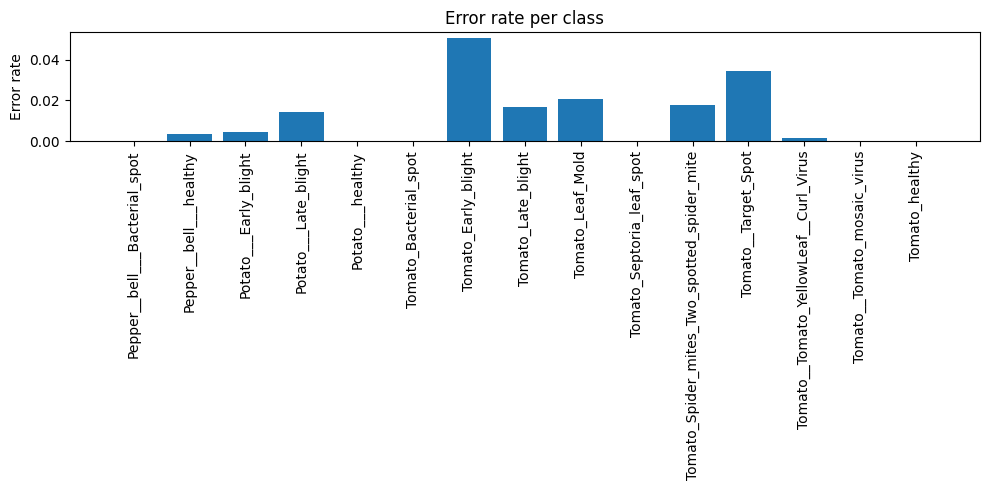

In [ ]:
error_rates = []
for cls in range(len(classes)):
    error_rates.append(
        error_count.get(cls,0) / class_total.get(cls,1)
    )

plt.figure(figsize=(10,5))
plt.bar(range(len(classes)), error_rates)
plt.xticks(range(len(classes)), classes, rotation=90)
plt.ylabel("Error rate")
plt.title("Error rate per class")
plt.tight_layout()
plt.show()

## **Final considerations**

We plotted a few charts to compare the results of the 4 approaches.

Another test on the different normalization is visible in the charts, this is due to the loss of an old dictionary and we would have to re execute everything to fix it.

Please ignore it.

In [ ]:
models = []
max_accs = []

for name, res in test_results.items():
    models.append(name)
    max_accs.append(max(res["test_acc"]))

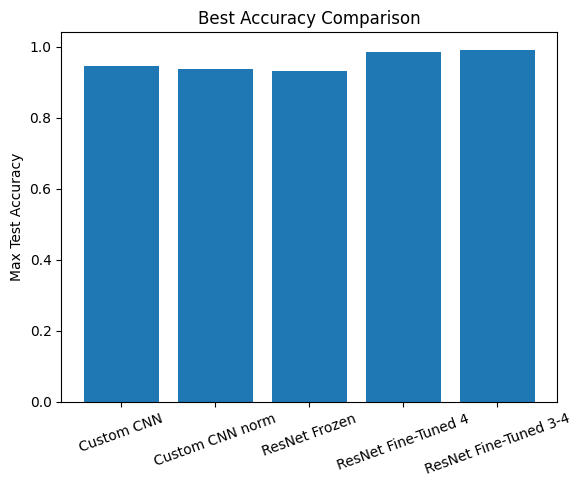

In [ ]:
plt.figure()
plt.bar(models, max_accs)
plt.ylabel("Max Test Accuracy")
plt.title("Best Accuracy Comparison")
plt.xticks(rotation=20)
plt.show()

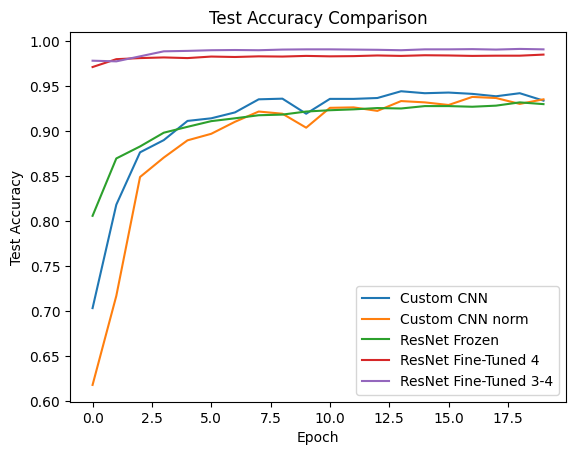

In [ ]:
plt.figure()

for name, res in test_results.items():
    plt.plot(res["test_acc"], label=name)

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Comparison")
plt.legend()
plt.show()

## **Code to save and upload for debugging**

In [ ]:
import pickle

with open("final.pkl", "wb") as f:
    pickle.dump(test_results, f)

from google.colab import files
files.download("final.pkl")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
uploaded = files.upload()

Saving test_AugDropout_AdamW.pkl to test_AugDropout_AdamW.pkl


In [ ]:
import pickle

with open("test_AugDropout_AdamW.pkl", "rb") as f:
    all_results = pickle.load(f)

In [ ]:
models_to_plot = [
    "Custom CNN",
    "ResNet Frozen",
    "ResNet Fine-Tuned 4",
    "ResNet Fine-Tuned 3-4"
]


In [ ]:
print(all_results.keys())

dict_keys(['Custom CNN', 'ResNet Frozen', 'ResNet Fine-Tuned'])
